# Exploratory Analysis #6: Explore Categorical Variables to Classify Company Status

In [44]:
from modules import *

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import scipy

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

In [46]:
#read in the data from data prep notebook
data = pd.read_hdf('results/classification_data.h5', 'classification_data')

Let's examine the data a bit, first the frequency of our response variable.

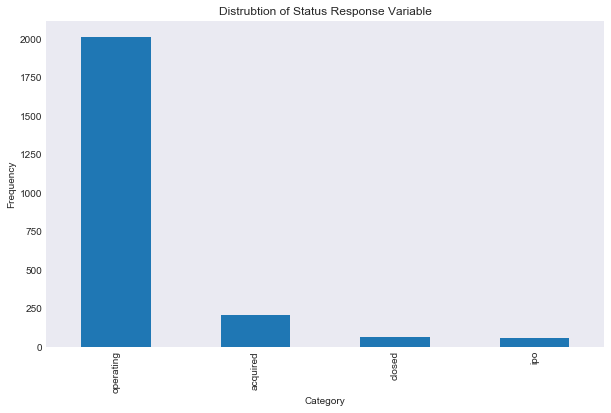

In [47]:
#frequencies of status variables
data['status'].value_counts().plot(kind = 'bar')
plt.title('Distrubtion of Status Response Variable')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.savefig("results/classification_status_variable_dist.png")

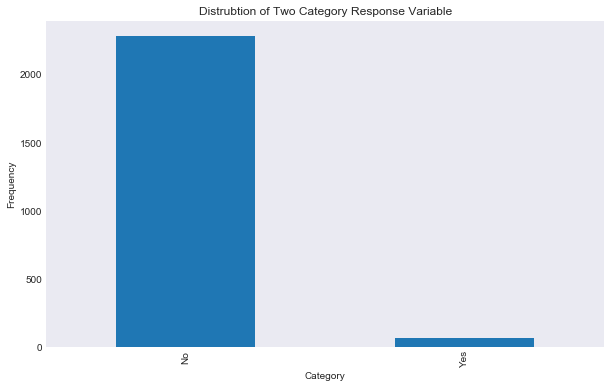

In [48]:
#frequncies of closed varible
data['closed'].value_counts().plot(kind = 'bar')
plt.title('Distrubtion of Two Category Response Variable')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.savefig("results/classification_closed_variable_dist.png")

As you can see the vast majority of the data represents companies that are still operating. I am going to start with the easier two class response closed vs not closed, and then move on to the company status. The issue that we have here, and one that we need to keep in mind for our classification models, is that we have a huge difference in our response variable prior probabilities. The issue may arrive when evaluated performance, here is an example of why this may be an issue. Say we are modeling a rare disease where 99.99 percent of our data does not have the disease and 0.01 percent of our data does have the disease. Then a model that just predicts "no" every time has an error rate of 0.0001, which is very low, but our model obviously sucks.

## Random Forest Classifier

I am going to start by using a random forest to classify status of a company. The reason I am going to focus on random forests is that random forests allow us to view the variable importance very easily, allowing us to see what predictors are most impactful in company status. Another reason random forests are nice in this case is that the sklearn RandomForestClassifier allows me to weight the response categories by setting class_weight, reducing the issue I discussed before of unbalanced prior probabilities. I also just want to try out sklearn's random forest classifier and compare it to the r package randomForest.

I did not realize sklearn's random forest method does not except categorical variables yet. So I'm going to have to convert a bunch of variables into dumby variables. I don't really like this, as an example why, say my 3 levels of a category are 'green', 'red', and 'blue' and an encoder make green = 0, red = 1, blue = 2. Then by this classification red is "in between" green and blue, when this is not the case. However, the alternative is create dumby columns for each category of each variable, and that would create a huge number of predictors, so for now I am going to go with the more naive approach.

In [49]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [50]:
#function to transform to encoded numerical variables
def transform_dumby(df, preds_index):
    """
    Description: transform a data predictors into dumby variables
    
    inputs:
        df: pandas data frame
        preds_index: preds_index: eiter an a two item list consisting of the start and stop column index or tuple of predictors column index or a single integer. If it is a single integer we assume this is the first index and predictors are the rest of the df.
    
    out: pandas df with encoded variables
    """
    rt_df = df.copy()
    
    if not isinstance(preds_index, int):
        start = preds_index[0]
        stop = preds_index[1]
        
        predictor_list = df.columns.values[start:stop]
    else:
        predictor_list = df.columns.values[preds_index:]
        
    for col_name in predictor_list:
        col = df[col_name]
        if not np.issubdtype(col.dtype, np.number):
            label_encoder = preprocessing.LabelEncoder()
            label_encoder.fit(col)
            new_col = label_encoder.transform(col)
            rt_df[col_name] = new_col
    return(rt_df)

In [51]:
#transform the data so random forest can use it
dat = transform_dumby(data, 3)
dat.head()

,closed,status,name,category_code,had_funding,num_investment,num_relationships,num_milestones,logo_height,logo_width,region,degree_type,institution,subject,birthplace,first_name,last_name
7,No,operating,Fundable.com,11,0,3.0,3.0,4.0,120.0,120.0,110,69,701,465,745,344,366
8,No,operating,Wevod,12,1,0.0,2.0,0.0,89.0,250.0,336,317,273,1116,330,797,634
11,No,acquired,Jumptap,22,1,0.0,45.0,3.0,165.0,650.0,57,52,26,352,980,1147,1748
18,Yes,closed,FairSoftware,40,1,0.0,1.0,1.0,67.0,250.0,372,317,894,394,790,29,1508
22,No,operating,WPP,30,0,21.0,23.0,3.0,59.0,86.0,309,199,1182,310,492,507,1731


Now I need to split into test and training sets. One common convention is to use 80 percent of the data as the training set.

In [52]:
#shape of the data
dat.shape

(2348, 17)

In [53]:
import random
#split into test and training set using 80 percent of the data
training = dat.sample(frac = 0.8, random_state = 1)
training.shape

(1878, 17)

In [54]:
#get test data being removing the training rows from data
training_index = list(training.index)

test = dat.drop(training_index, axis = 0)
test.shape

(470, 17)

Now I can seperate the predictors and response variables in the training and test data.

In [55]:
#function to seperate predictors and response in one line
def seperate_preds_response(df, response_var, preds_index):
    """
    decription: function that makes it so I don't have to split into predictors and response for test and traiing data.
    
    inputs:
        df: training or test data frame
        response_var: either a string of the name of the response variable or a list of strings for multiple different response variables
        preds_index: eiter an a two item list consisting of the start and stop column index or tuple of predictors column index or a single integer. If it is a single integer we assume this is the first index and predictors are the rest of the df.
    output:
        List of predictors and response. 
        First item of the list is the data frame of predictors. The rest are the response series.
    """
    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError("df must be Pandas DFs")
        
    dfs = []
    
    if not isinstance(preds_index, int):
        start = preds_index[0]
        stop = preds_index[1]
        
        predictor_list = df.columns.values[start:stop]
    else:
        predictor_list = df.columns.values[preds_index:]
        
    predictors = df[predictor_list] 
    
    dfs.append(predictors)
    
    for var in response_var:
        if not isinstance(var, str):
            raise TypeError("columns of response_var must be strings in the data frame")
            
        resp = df[var]
        dfs.append(resp)
        
    return(dfs)

In [56]:
#seperate predictors and response
train_preds, train_closed, train_status = seperate_preds_response(training, ['closed', 'status'], 3)

test_preds, test_closed, test_status = seperate_preds_response(test, ['closed', 'status'], 3)

In [57]:
#training shape
train_preds.shape

(1878, 14)

In [58]:
#test shape
test_preds.shape

(470, 14)

I am now going to fit a random forest classifier on the status of the data.

In [59]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier

In [60]:
from sklearn.model_selection import GridSearchCV

Before I fit the random forest model I am going to use GridSearchCV to perform cross validation in order to tune the hyperparameters of the random forest. In the case of this random forest I am going to tune the number of trees in the random forest 'n_estimators', the parameter 'max_features', and the maximum depth (terminal nodes) of the tree 'max_depth'. The 'max_features' parameter is the most important parameter for random forests, and determines the maximum number of predictors to random forest will look at when decided how to best split the data. The reason random forests do not look at all of the predictors in the data when creating splits lies in the bias-variance trade off: the random forest will risk increasing bias while reducing variance in limiting the maximum number of features. This reduces any error causes my highly correlated predictors.

Cross Validation allows us to tune these hyperparameters. When looking at the predictive power of a learning model, the accuracy of the model in predicting the data used to train it is a dis-honest evaluation of the model. Cross Validation splits the data in k folds, then for each value of the hyperparameters we are looking at it training the model on all but one of the folds at a time, tests the model on each left out fold. The average perforamnce of each of the k folds is used as the estimated performance of the hyperparameters. Using GridSearchCV I can find the best combination of my two hyperparameters. 

In [61]:
#list of number of predictors examined in the CV
num_preds = np.arange(2, np.ceil(train_preds.shape[1] / 2)).astype(int)

#list of the number of trees used in the CV
n_ests = [50, 100, 150, 200, 250]

#max depth
m_depth = np.arange(1, 11)

Note that for scoring I am using an f1 score, f1_weighted. This is to attempt to not overclassify the highly frequent "operating" status. For example, I will show an example after these steps as to what happens when I use accuracy.

In [62]:
#dictionary of parameters to be tuned
params = {'max_features':  num_preds, 'max_depth': m_depth, 'n_estimators': n_ests}

The cell below may take a view minutes to run. As side note, while this next cell does take a but of time to run, if we run to do the same in r it would take much longer. GridSearchCV is one of the most usefull parts of sklearn in my limited experience with it.

In [63]:
#intialize a random forest classifier.
#random state sets the random set of the classifier
#class_weight = 'balanced_subsample'
rcf = RandomForestClassifier(random_state = 100, class_weight = 'balanced')

#do 5-fold cross validation the hyperparameters
cv_rcf = GridSearchCV(rcf, params, cv = 5, scoring = 'f1_weighted', return_train_score = False)

#fit the training data
cv_rcf.fit(train_preds, train_status)

/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackm

/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackm

/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackm

/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackm

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([2, 3, 4, 5, 6]), 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), 'n_estimators': [50, 100, 150, 200, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1_weighted', verbose=0)

In [64]:
def plot_cross_validation_result(cv_model, col, hue, x_var, title, savefig):
    """
    description: plot results of parameter tuning cross validation with 3 parameters
    inputs:
        cv_results: GridSearchCV object with cv_results_ instance
        col: String, column name in cv_results_ to facet
        hue: String, column in cv_results_ to split by
        x_var: String, column in cv_results_ to plot as x
        title: String, title
        savefig: savefig file name
    """
    cv_results = pd.DataFrame(cv_model.cv_results_)
    scores = cv_results[['mean_test_score', col, hue, x_var]]
    
    p = sns.FacetGrid(data = scores, col = col, hue = hue, col_wrap=3)
    p.map(plt.plot, x_var, 'mean_test_score').add_legend()
    plt.suptitle(title)
    p.fig.subplots_adjust(top=0.9)
    plt.savefig(savefig)

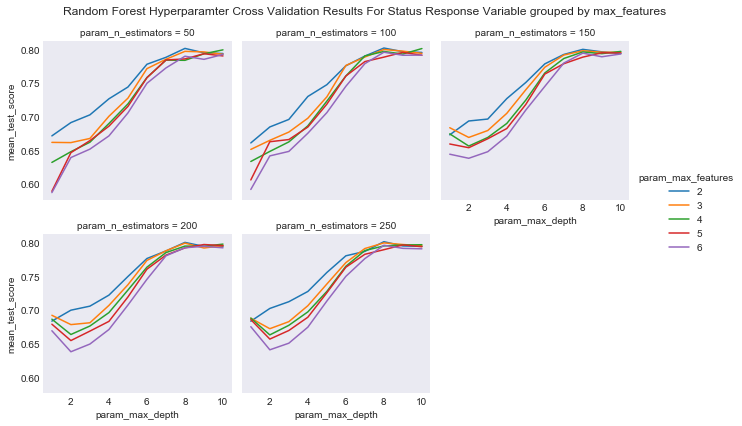

In [65]:
#plot the results of the cross validation grouped by max_features and faceted by number of trees
plot_cross_validation_result(cv_rcf, 'param_n_estimators', 'param_max_features', 'param_max_depth',
                             "Random Forest Hyperparamter Cross Validation Results For Status Response Variable grouped by max_features",
                             "results/rf_cv_results_status_max_features.png")

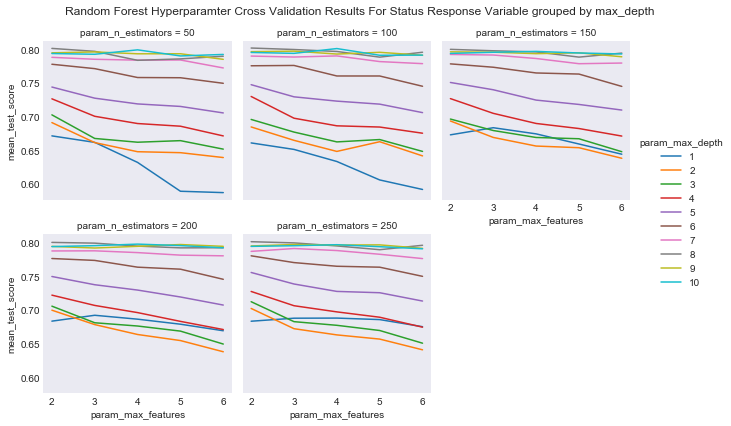

In [66]:
#plot the results of the cross validation grouped by max_depth and faceted by number of trees
plot_cross_validation_result(cv_rcf, 'param_n_estimators', 'param_max_depth', 'param_max_features',
                             "Random Forest Hyperparamter Cross Validation Results For Status Response Variable grouped by max_depth",
                             "results/rf_cv_results_status_max_depth.png")

I can now fit a random forest using the best combination of hyperparameters.

In [67]:
#fit the best cross validation random forest
best_rcf = cv_rcf.best_estimator_

In [68]:
def var_imp_plot(model, train_preds, title, savefig, score = 'gini'):
    """
    description: plot variable importance for randomforest and extratrees model
    inputs:
        model: sklearn randomforest or extratrees model
        train_preds: list of training predictor column names
        title: title of plot
        savefig: savefig name
        score: (option) String, evaluation parameter, deafult set to gini, if not default supply own vector of variable importance
        
    output:
        variable importance plot
    """
    if score == 'gini':
        imps = model.feature_importances_
    else:
        imps = score
    x = range(train_preds.shape[1])
    feature_names = train_preds.columns
    
    f, ax = plt.subplots()
    plt.bar(x, imps, color = 'b', align = 'center')
    plt.xticks(x, feature_names, rotation='vertical')
    plt.xlim(-1, train_preds.shape[1])
    plt.ylabel("Importance")
    plt.xlabel("Variable")
    plt.title(title)
    plt.savefig(savefig)   

Now I can look at the feature importance of each variable. This is the variable that best splits the data into the status categories.

In [69]:
#create data frame of variable importance
d = {'variable': train_preds.columns.values, 'gini': best_rcf.feature_importances_}
feature_imp = pd.DataFrame(d)
feature_imp

,gini,variable
0,0.059958,category_code
1,0.047761,had_funding
2,0.061400,num_investment
3,0.167173,num_relationships
4,0.080897,num_milestones
5,0.079395,logo_height
6,0.075504,logo_width
7,0.057165,region
8,0.045197,degree_type
9,0.069924,institution


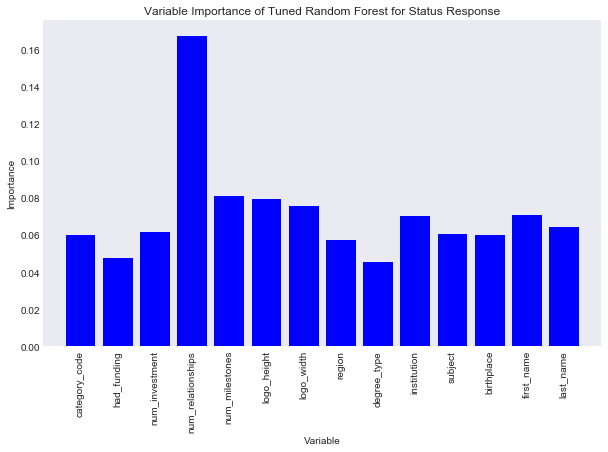

In [70]:
title = "Variable Importance of Tuned Random Forest for Status Response"
savefig = "results/variable_importance_status_random_forest.png"
var_imp_plot(best_rcf, train_preds, title, savefig)

It seems num_relationships best splits our data into the status categories.

Now I am going to move on to testing. Recall before I mentioned how the issue of class imbalance may effect our learning model. While we were able to find out number of relationships split the data well the status category, we still don't know how well that model predicts unseen data? First let's look at the accuracy of our model.

In [71]:
#look at accuracy of the data
test_status_score = best_rcf.score(test_preds, test_status)
test_status_score

0.82340425531914896

That's not horrible. However, I mentioned before the issue when attempting to classify on a data set with highly unbalanced accuracy is that a model can return "accurate" results by simply classifying every observation as the class with the overwhelmingly high frequency. Below I will show the confusion matrix of the predictions our model made. In a confusion matrix, the number in the ith row and jth column is the number of individuals we predicted to be in the "ith" class, but is really in the "jth" class, based on some ordering. I provide the ordering in a list before the confusion matrix is printed.

In [72]:
from sklearn.metrics import confusion_matrix
#class predictions
preds_status_forest = best_rcf.predict(test_preds)
#confusion matrix
labs = list(set(test_status))
print(labs)
cf = confusion_matrix(y_true = test_status, y_pred = preds_status_forest, labels = labs)
print(cf)

['acquired', 'closed', 'operating', 'ipo']
[[  4   0  31   0]
 [  3   2   9   0]
 [ 19   6 377   5]
 [  2   0   8   4]]


Before I said I would show what happened with the best results based on accuracy. Accuracy and tree depth are highly correlated, and deep trees can provide very accurate results, but overfit. You can see that tree depth is almost maximum for our best random forest model here based on f1_score, because f1 score is still reliant on us getting many accurate "operating" classifications. However, if I had kept the score on accuracy in the cross validation process, I would have gotten a model with maximum tree depth. Let's look at what happens in that case, by keeping all other parameters constant.

In [73]:
rcf_max_depth = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=2,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=10, random_state=100, verbose=0, warm_start=False)
rcf_max_depth.fit(train_preds, train_status)
rcf_max_depth.score(test_preds, test_status)

0.86808510638297876

In [74]:
#class predictions
preds_max = rcf_max_depth.predict(test_preds)
#confusion matrix
labs = list(set(test_status))
print(labs)
cf = confusion_matrix(y_true = test_status, y_pred = preds_max, labels = labs)
print(cf)

['acquired', 'closed', 'operating', 'ipo']
[[  0   0  35   0]
 [  0   0  14   0]
 [  0   0 407   0]
 [  0   0  13   1]]


Similar results would have occured if we had set max_depth to none. As you can see, the model did not do very well. Very few cases in the test sample were predicted to be not 'operating', showing the model really is not predicting anything, this shows the issue with model accuracy. You can see that the model based on the weighted f1 scores really does not perform much better, and is still overpredicting operating. I could have based the scoring criteria only on precision, but then model accuracy would suffer.

As a side note, I struggled with what you see above for a long time. In r, dealing with these kind of datasets tends to be a little easier, and when searching for ways to solve the issue of overpredicting frequent classes I read some pretty heated comments on stack overflow by people critizing sklearn for people behind.

One way to make this problem a little easier to to switch to a two variable case, and base the cross validation scoring statistic to AUC. Using sklearn, I can do is switch to binary variables and fit my models hyper-parameters using the sklearn's roc_auc_score to measure test performance via auc. A receiver operating characteristic curve (ROC curve) is a good way to measure predictive performance of a two class response variable. AUC, short for area under the curve, provides a performance metric for a predictive model by calculating the area under the ROC curve.

### Closed

First, I realized that sklearn prefers binary 1 or 0 encoding for categorical responses in order to find the ROC curve and AUC so I am going to switch the encoding. Then I will run the sam process as before, but this time on the binary variable indicating whether a business was closed or not.

In [75]:
#change encoding
train_closed_binary = [1 if v == 'Yes' else 0 for v in train_closed]

Note: the below cell may take a while

In [76]:
#make closed model
#params = {'max_features':  num_preds, 'n_estimators': n_ests}
params = {'max_features':  num_preds, 'max_depth': m_depth, 'n_estimators': n_ests}

rcf_closed = RandomForestClassifier(random_state = 100, class_weight = 'balanced')

cv_rcf_closed = GridSearchCV(rcf_closed, params, cv = 5, scoring = 'roc_auc',
                      return_train_score = False)

#cv_rcf.fit(train_preds, train_closed)
cv_rcf_closed.fit(train_preds, train_closed_binary)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([2, 3, 4, 5, 6]), 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), 'n_estimators': [50, 100, 150, 200, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=0)

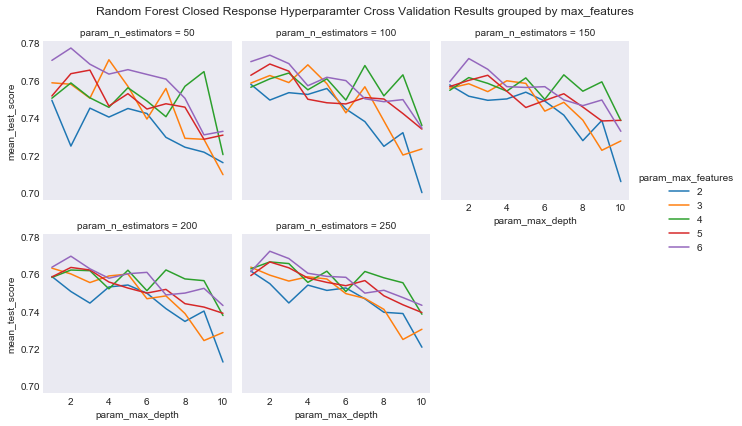

In [77]:
#plot grouped by max_features
plot_cross_validation_result(cv_rcf_closed, 'param_n_estimators', 'param_max_features',
                             'param_max_depth',
                             "Random Forest Closed Response Hyperparamter Cross Validation Results grouped by max_features",
                             'results/rf_closed_cv_results_max_features.png')

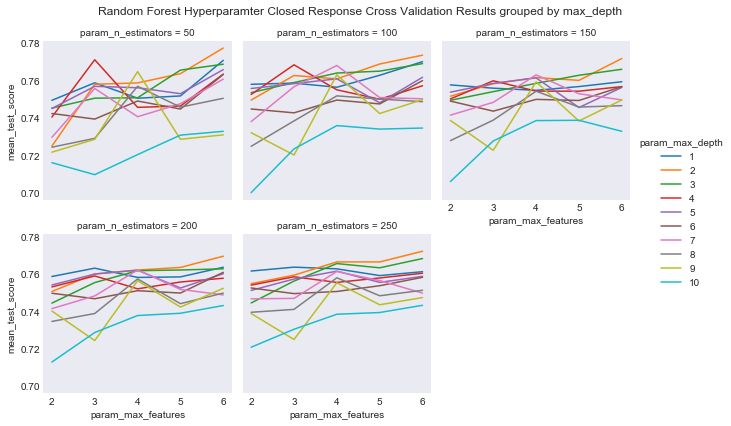

In [78]:
#plot grouped by max_depth
plot_cross_validation_result(cv_rcf_closed, 'param_n_estimators','param_max_depth',
                             'param_max_features', 
                             "Random Forest Hyperparamter Closed Response Cross Validation Results grouped by max_depth",
                             'results/rf_closed_cv_results_max_depth.png')

In [79]:
#fit the best model based on the best hyperparameters
best_rcf_closed = cv_rcf_closed.best_estimator_

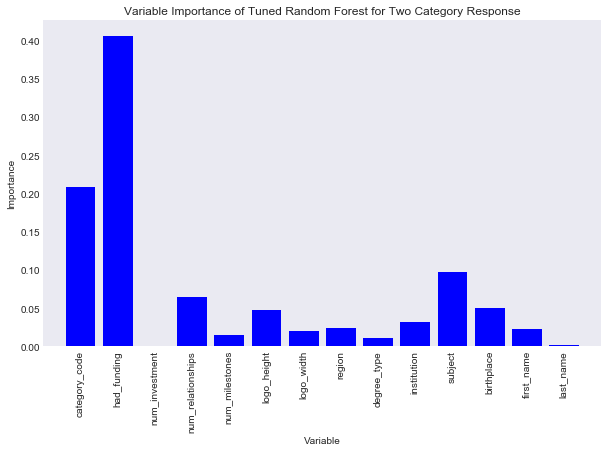

In [80]:
title = "Variable Importance of Tuned Random Forest for Two Category Response"
savefig = "results/random_forest_two_class_variable_importance.png"
var_imp_plot(best_rcf_closed, train_preds, title, savefig)

Now it seems the feature that is the most important is had_funding, followed by category_code. The number of investments is suprisingly low, however last name of founder is also very low in importance for determining the status of a company, which is expected. One other thing I notice, school subject of a founder is more important than the institution of a founder, which is more important than the degree type.

Now we can look at the test performance of our new random forest model. Let's start with accuracy.

In [81]:
#encode test response variibale
test_closed_binary = [1 if v == 'Yes' else 0 for v in test_closed]
#look at test score
best_rcf_closed.score(test_preds, test_closed_binary)

0.7191489361702128

This is low, much lower than the test score we got for our previous random forest. However, the issue there was that the model had no true predictive power.

In [82]:
#look at test confusion matrix
preds_closed_forest = best_rcf_closed.predict(test_preds)
#confusion matrix
labs = list(set(test_closed_binary))
print(labs)
cf_closed = confusion_matrix(y_true = test_closed_binary, y_pred = preds_closed_forest, labels = labs)
print(cf_closed)

[0, 1]
[[327 129]
 [  3  11]]


Now you can see that the model is actually predicting negative cases. In the model on status we were constantly predicting a business would be operating, and were rarely able to predict when a business would have any other status. In this case, we were able to predict almost all of the closed businesses, even though we predicted many operating business would be closed.

The issue now with the model is the high false positve rates, but in the data sets like the one we are working with, this example becomes a lot like attempting to predict a rare disease. When predicting a rare disease, obviously having too high of a false positive rate is much prefferable to a high false negative rate. While originally we set out to attempt find out how to predict succes, I'm actually now kind of trying to find how to predict failure.

Remember I picked the hyperparameters of this model based on the AUC score, so let's look at our model performance bu looking at the ROC curve and AUC statistic.

In [83]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
def roc_auc_plot(model, title, savefig):
    """
    description: plot the roc and report the auc of a curve
    inputs:
        model: learning model with two category response
        title: title
        savefig: savefig file
        
    outputs:
        ROC curve
        auc
    """
    pred_probs_closed_pos = model.predict_proba(test_preds)[:,1]
    fpr, tpr, thresh = roc_curve(test_closed_binary, pred_probs_closed_pos)
    auc = roc_auc_score(test_closed_binary, pred_probs_closed_pos)
    auc_str = "AUC: " + str(auc)
    print(auc_str)
    
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.title(title)
    plt.xlabel("True Positve Rate")
    plt.ylabel("False Negative Rate")
    plt.savefig(savefig)

AUC: 0.794564536341


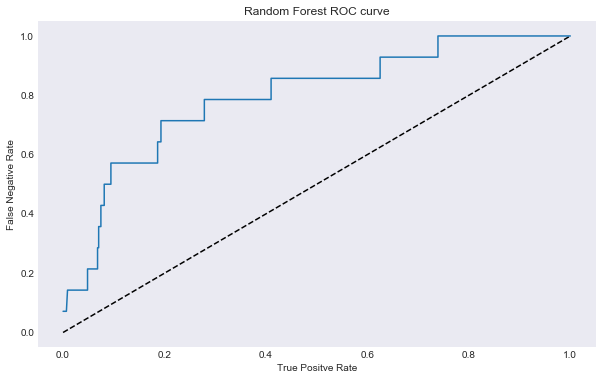

In [84]:
roc_auc_plot(best_rcf_closed, title = "Random Forest ROC curve", savefig = "results/random_forest_roc_curve")

Once again our performance isn't great. If we wanted great performance we could have turned every feature into a dumby indicator variable and run a KNN model, however, then we would not have any good inference on important features, and would have run the risk of overfitting the data. 

## Extremeley Randomized Trees Classifier

I spent a lot of time reading sklearn documentation for this project on models I was familiar with, and several time I just theme suggest reading the ExtraTreesClassifier. I had not heard of an Extra Trees model before, so I did some research and read some of [this](http://www.montefiore.ulg.ac.be/~ernst/uploads/news/id63/extremely-randomized-trees.pdf) paper from 2006 introducing Extremeley Randomized Trees, or in sklearn speak ExtraTrees. 

Extremeley Randomized Trees are very similar to Random Forests, and sklearn sets up the user input up in a very similar way. Extremeley Randomized Trees are similar to Random Forests in that they take a random rubsample of features, but drops the idea of bootstraping many trees samples in order to find optimal cut off points for feature node splits, and instead randomizes the picks a decision boundary at random for these node splits. This is why they are "extremeley" random, and as far as the bias-variance tradeoff is concerned, the model's increase in randomness seeks to further lower the variance of a model. Based on what I read, the performance of Extremley Randomized Trees can be similar, if not usually better, than that of a Random Forest.

I am going to use GridSearchCV to tune the hyperparameters of the model again, however, this time I am not tuning the number of trees, or n_estimators, of the model. There are several reasons for this, for one, in general as the number of trees increases, generally model accurately increases at the sake of increases runtime, and I this notebook already has several cells that can take a few minutes to run. In addition, as the number of estimators increases, so does generally the chance of overfitting, and I am purposely using ExtraTrees for its ability to reduce model variance. 

In [85]:
from sklearn.ensemble import ExtraTreesClassifier

params_two = {'max_features' : num_preds, 'max_depth' : m_depth}

ext = ExtraTreesClassifier(n_estimators = 100, criterion = 'gini',
                           class_weight = 'balanced', random_state = 5)

cv_ext = GridSearchCV(ext, params_two, cv = 5, scoring = 'f1_weighted',
                      return_train_score = False)

cv_ext.fit(train_preds, train_status)

/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackmoorer/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jackm

GridSearchCV(cv=5, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=5, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([2, 3, 4, 5, 6]), 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1_weighted', verbose=0)

In [86]:
def plot_cv_two_param(cv_model, group, x_var, ylab, title, savefig):
    """
    description: similar to plot before, but now with two hyperparameters
    inputs:
        cv_model: GridSearchCV model
        group: column name to group by
        xvar: param to put on x variable
        y_lab: metric used for cv
        title: title
        savefig: savefig file
    """
    ext_cv_results = pd.DataFrame(cv_model.cv_results_)
    ax = plt.subplot()
    ext_cv_results.groupby(group).plot(y = 'mean_test_score',
                                               x = x_var,
                                              kind = 'line', ax = ax)
    leg = plt.legend()
    ax.set_xlim(0, 11)
    for item, text in zip(leg.texts, num_preds):
        plt.setp(item, 'text', text)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    plt.savefig(savefig)

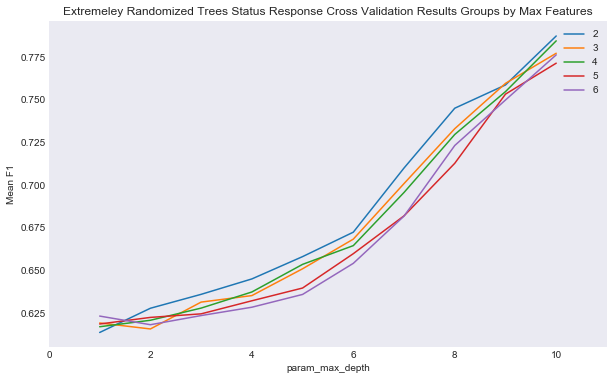

In [87]:
#plot cv results
plot_cv_two_param(cv_ext, 'param_max_features', 'param_max_depth', 'Mean F1',
                  "Extremeley Randomized Trees Status Response Cross Validation Results Groups by Max Features",
                  'results/extra_trees_status_cv_results.png')

In [88]:
#fit extremeley randomized tree
best_ext = cv_ext.best_estimator_

Let's look at the variable importance plot.

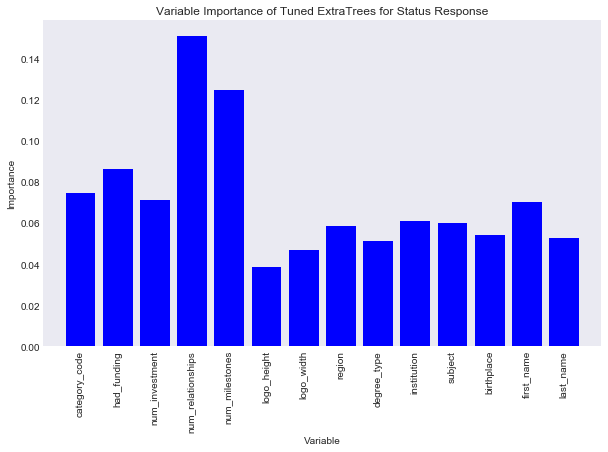

In [89]:
#plot var importance
title = "Variable Importance of Tuned ExtraTrees for Status Response"
savefig = "results/variable_importance_status_extra_trees.png"
var_imp_plot(best_ext, train_preds, title, savefig)

Like the Random Forest model on status number of relationships is the most important, but now number of milestones is also important. Let's look at the perforamnce of this model.

In [90]:
#report test score
acc = best_ext.score(test_preds, test_status)
acc

0.78936170212765955

This is worse than for our Random Forest model on the status variable, but let's look at the confusion matrix.

In [91]:
#report confusion matrix
pr = best_ext.predict(test_preds)
labs = list(set(test_status))
print(labs)
confusion_matrix(y_true = test_status, y_pred = pr, labels = labs)

['acquired', 'closed', 'operating', 'ipo']


array([[  6,   4,  25,   0],
       [  5,   3,   6,   0],
       [ 19,  24, 358,   6],
       [  3,   2,   5,   4]])

Unlike the random forest, the extremeley randomized tree is able to predict other classes, however, not very accurately. I do think that if I had tuned the number of estimators along side it I could have gotten better results, but I want to conserve runtime on this notebook. Notice once again I used accuracy as the perfomance score. This ended up yeilding that the greatest maximum depth of the tree yeilded the best results. This is what happened for the random forest model as well. Accuracy will increase an depth increases, so accuracy is just not a good metric to try to tune tree depth. I can quickly see what would happen if the tree had a lower max depth keeping the maximum feature parameter constant.

In [92]:
def quick_examine_extra(depth):
    """
    descrition: function to quickly examine how results change for depth change ExtraTrees
    input:
        max_depth: int, max depth of the tree
    output:
        print:
            model accuracy
            confusion matrix
        return:
            model with depth param
    """
    
    ext_depth = ExtraTreesClassifier(n_estimators = 100, criterion = 'gini',
                           class_weight = 'balanced', random_state = 5,
                                  max_features = 2, max_depth = depth)
    ext_depth.fit(train_preds, train_status)
    
    acc = ext_depth.score(test_preds, test_status)
    
    
    pr = ext_depth.predict(test_preds)
    labs = list(set(test_status))
    cf = confusion_matrix(y_true = test_status, y_pred = pr, labels = labs)
    
    print("Accuracy is:",  acc)
    print(labs)
    print(cf)
    
    return(ext_depth)

In [93]:
#depth 2 tree
ext_depth_2 = quick_examine_extra(2)

Accuracy is: 0.542553191489
['acquired', 'closed', 'operating', 'ipo']
[[  0  18  13   4]
 [  0  11   3   0]
 [  3 147 241  16]
 [  0   5   6   3]]


In [94]:
#depth 5 tree
ext_depth_5 = quick_examine_extra(5)

Accuracy is: 0.578723404255
['acquired', 'closed', 'operating', 'ipo']
[[  0  17  12   6]
 [  1  10   3   0]
 [ 22 115 253  17]
 [  1   4   0   9]]


In [95]:
#depth 8 tree
ext_depth_8 = quick_examine_extra(8)

Accuracy is: 0.697872340426
['acquired', 'closed', 'operating', 'ipo']
[[  6  11  18   0]
 [  4   4   6   0]
 [ 39  49 311   8]
 [  5   1   1   7]]


We can see that smaller values of depth allow us to better predict closed, but not small tree depths make it difficult for the tree to predict acquired and ipo. What would happen if we picked a depth outside of the corss validation range I picked?

In [96]:
#depth 12 tree
ext_depth_12 = quick_examine_extra(12)

Accuracy is: 0.840425531915
['acquired', 'closed', 'operating', 'ipo']
[[  4   0  31   0]
 [  3   1  10   0]
 [ 10   7 388   2]
 [  1   0  11   2]]


Here the perforamance begins to act more like it did for the best random forest model. Accuracy is high, but that is just because the model overpredicts operating.

It is difficult to say which of ExtraTrees and RandomForest performed better on the status dataset, however, the fact that most gave similar variable importance statistics gives us a good idea about which features are important in creating this decision trees.

<img src='results/variable_importance_status_random_forest.png'>

 <img src='results/variable_importance_status_extra_trees.png'>

It looks like for both tree based methods number of relationships is the most important variable. Number of milestones is also important for both types of methods. Interestingly, first name is as important or more important than features many features, including academic features.

### Closed

I am going to repeat the process of using the two category feature on closed.

In [97]:
params_two = {'max_features' : num_preds, 'max_depth' : m_depth}

ext_closed = ExtraTreesClassifier(n_estimators = 100, criterion = 'gini',
                           class_weight = 'balanced', random_state = 5)

cv_ext_closed = GridSearchCV(ext_closed, params_two, cv = 5, scoring = 'roc_auc',
                      return_train_score = False)

cv_ext_closed.fit(train_preds, train_closed_binary)

GridSearchCV(cv=5, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=5, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([2, 3, 4, 5, 6]), 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=0)

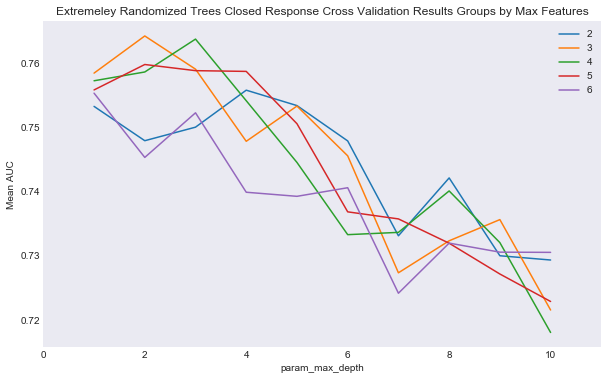

In [98]:
plot_cv_two_param(cv_ext_closed, 'param_max_features', 'param_max_depth', 'Mean AUC',
                  "Extremeley Randomized Trees Closed Response Cross Validation Results Groups by Max Features",
                  'results/extra_trees_closed_cv_results.png')

In [99]:
best_ext_closed = cv_ext_closed.best_estimator_

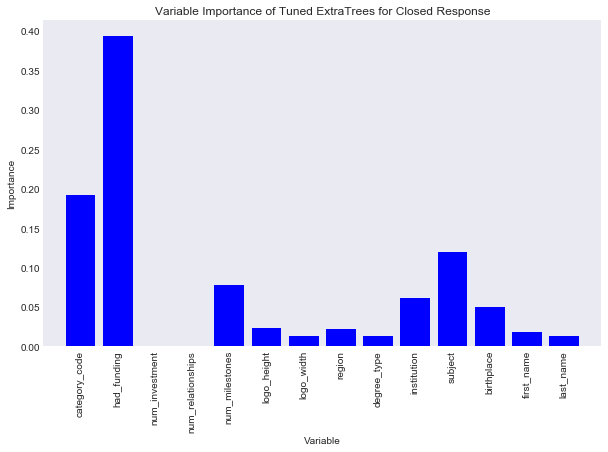

In [100]:
#plot var importance
title = "Variable Importance of Tuned ExtraTrees for Closed Response"
savefig = "results/variable_importance_closed_extra_trees.png"
var_imp_plot(best_ext_closed, train_preds, title, savefig)

Similar to the random forest closed variable importance plot, whether the company had funding, what category the company was, and the school subject of the founder were relatively important variables. One interesting note here is taht the number of relationships is now note important.

In [101]:
#look at accuracy
acc = best_ext_closed.score(test_preds, test_closed_binary)
acc

0.63404255319148939

This is a very low accuracy, let's look at the confusion matrix.

In [102]:
#report confusion
pr_closed = best_ext_closed.predict(test_preds)
labs = list(set(test_closed_binary))
print(labs)
confusion_matrix(y_true = test_closed_binary, y_pred = pr_closed)

[0, 1]


array([[287, 169],
       [  3,  11]])

That is very similar to the confusion matrix, in fact, it looks like this model just overpredicts "No" without actually improving the ability to predict "No" seemingly to imply, in this case, Random Forest is ideal. Let's look at the ROC and AUC.

AUC: 0.715068922306


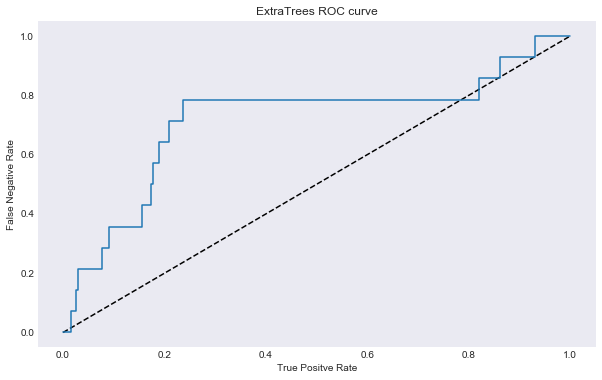

In [103]:
roc_auc_plot(best_ext_closed, title = "ExtraTrees ROC curve", savefig = 'results/extra_trees_roc_curve.png')

This model really did not perform well. The black dotted line on the ROC curve donates the ROC of a random classify that classifies "Yes" or "No" by random. This mean this extratrees classifier, at times, is worse than a random guess classifier.

We can still examine the varible importances of the random forest vs the extremeley randomized tree to see if we can gather any insights

<img src='results/random_forest_two_class_variable_importance.png'>

<img src='results/variable_importance_closed_extra_trees.png'>

Had funding clearly looks like an important feature to predicting whether a business is closed or not based on our tree based bethods. Category code also seems to be an important variable for both methods. Because the methods are very similar in nature, it is not a suprise both ranomd forests and extremely randomized trees gave similar variable importance for the two response variable.

In the two category case it seemed like random forest performed better than extremely randomized trees.

## Looking at Data using Dumby

In order to run the tree based methods in this section I had to encode the features becasue sklearn does not accept categorical variables. In this section instead of encoding the variables, I am going to look at only the categorical features by creating a longer dumby matrix.

In [104]:
start_preds, all_closed, all_status = seperate_preds_response(data, ['closed', 'status'], 3)

In [105]:
long_preds = pd.get_dummies(start_preds)
long_preds.shape

(2348, 7996)

In [106]:
long_preds.head()

,num_investment,num_relationships,num_milestones,logo_height,logo_width,category_code_advertising,category_code_analytics,category_code_automotive,category_code_biotech,category_code_cleantech,...,last_name_paunikar,last_name_raj,last_name_rokade,last_name_seo,last_name_sk,last_name_termini,last_name_van Apeldoorn,last_name_van Loo,last_name_van der Chijs,last_name_von Wallenstein
7,3.0,3.0,4.0,120.0,120.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0.0,2.0,0.0,89.0,250.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0.0,45.0,3.0,165.0,650.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0.0,1.0,1.0,67.0,250.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,21.0,23.0,3.0,59.0,86.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


With get_dummies, pandas turns my data frame into a completely numeric data drame by splitting any categorical features into dumby variables. I am going to only keep the categorical dumby variables in this section

In [107]:
long_preds_cat = long_preds.drop(['num_investment', 'num_relationships', 'num_milestones', 'logo_height', 'logo_width'], axis = 1)

I am now going to examine the data in two dimensions using MDS like last project. I considered running a PCA in order to do a dimension reduction, but I decided against it.

I am going to focus on Eucliean Distances rather than Jensen-Shannon divergence. The reason I am doing this is that orgianlly I had planned on fitting a KNN on the data using euclidean distances. However, due to the curse of dimensionality it was have been important to first do feature selection to reduce the dimensions of the data. I first wanted to look at a 2D few of these distances using MDS, and you will see the result. 

In [108]:
#take transpose so that features are rows
pres_mat = long_preds_cat.transpose()

In [109]:
#normalize on probability scale
column_sums = pres_mat.sum(axis = 0).values
pmm = pres_mat / column_sums

In [110]:
#look at shape of data
pmm = np.array(pmm)
pmm.shape

(7991, 2348)

The next code chunk takes a very long time.

In [111]:
#calculate euclidean distances
from scipy.spatial import distance

#Intialize empty matrix of Euclidean distances
euc_dists = np.zeros(shape = (pmm.shape[1], pmm.shape[1]))

#loop through columns
for i in range(pmm.shape[1]):
    #catch first column to compare
    cur_col = pmm[:, i]
    #loop through remaining columns
    for j in range(i, pmm.shape[1], 1):
        #catch second column to compare
        comp_col = pmm[:, j]
        
        #compute Euclidean Distance
        euc_dist = distance.euclidean(cur_col, comp_col)
        euc_dists[i, j] = euc_dist
        
        if (i != j):
            euc_dists[j, i] = euc_dist

In [112]:
#fit MDS in 2 dimensions to get 2 dimensional view
from sklearn.manifold import MDS
mds = MDS(n_components = 2, dissimilarity='precomputed', random_state=123)
mds_fit = mds.fit(euc_dists)
points = mds_fit.embedding_

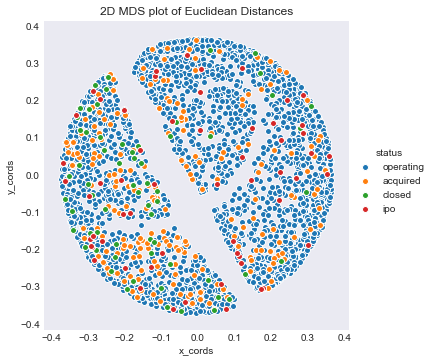

In [113]:
#intialize data frame for plots
dists = {'status': all_status,
     'closed': all_closed,
     'x_cords': points[:, 0],
     'y_cords': points[:, 1]}
mds = pd.DataFrame(dists)

#plot via status
sns.pairplot(x_vars = 'x_cords', y_vars = 'y_cords', data = mds,
             hue = 'status', size = 5)
plt.title("2D MDS plot of Euclidean Distances")
plt.savefig("results/mds_euc_status.png")

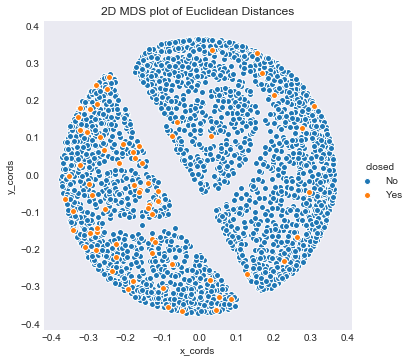

In [114]:
#plot via closed
sns.pairplot(x_vars = 'x_cords', y_vars = 'y_cords', data = mds,
             hue = 'closed', size = 5)
plt.title("2D MDS plot of Euclidean Distances")
plt.savefig("results/mds_euc_closed.png")

As you can see there is no clear pattern in seperation based on Euclidean distances, do a method like a KNN would possibly not be affective in a situation like this.

This may also partly explaine why the tree based methods in the previous section had trouble classifying the data. It may be that the features we are looking are aren't really indicators of success or failure in business.

## Final Thoughts

In this notebook we tried to classify business status via categorical variables about business location and founders. In doing so, we were not only looking to build an accurate model, we also wanted to understand feature importance in order to identify categorical variables that predicted business success or failure.

We used two random tree based methods, Random Forest and Extremely Randomized Trees as our predictive models. These methods were choosen primarly for their ability to report feature importance, and this notebook acted an a comparison of the two similar models. I also wanted to compare sklearn's RandomForestClassifier with the r package randomForest.

Prediction was difficult, primarly due to highly imbalanced reponse categories. We were still able to extract feature importances for the status and closed reponse variables and measure the test performance of each model. 

Finally, we decided to convert the purely string based categorical variables in a dumby data frame and and examine a two dimensional view of the categorial used Euclidean Distances and MDS. This showed that, while we were able to extract the importance of the features used, these features may not actually seperate the data enough to predict company status. Further analysis certainly could have been done, but the runetime on this notebook is already significant so we kind of leave with an ambigous answer to our question of what categorical features predict company status.